# Read and Code

- ## The Expectation Maximization Algorithm
- https://www.cc.gatech.edu/~dellaert/em-paper.pdf  
- WForfang  
- 10/22/17


In [3]:
%load_ext watermark
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# import seaborn as sns
import numpy as np
%watermark -v -m -p numpy,seaborn -g

CPython 2.7.13
IPython 4.0.3

numpy 1.11.3
seaborn 0.6.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 


## Helpers

In [4]:

def normval(x, mu,sigma):
    # x: <numpy array> = range over which to compute normal PDF
    # mu: <float> = mean of normal pdf
    # sigma: <float> = std of normal pdf
    mu = float(mu)
    sigma = float(sigma)
    return 1.0/(sigma*np.sqrt(2*np.pi))*np.exp((-(x.astype('float')-mu)**2)/(2*sigma**2))

def uGivenMu(U,mu,sigma=1.0):
    return np.exp(-.5*sigma**2*(U.astype('float')-float(mu))**2)

def sse(x, mu):
    return (x.astype('float')-mu)**2

## Figures 1 and 2

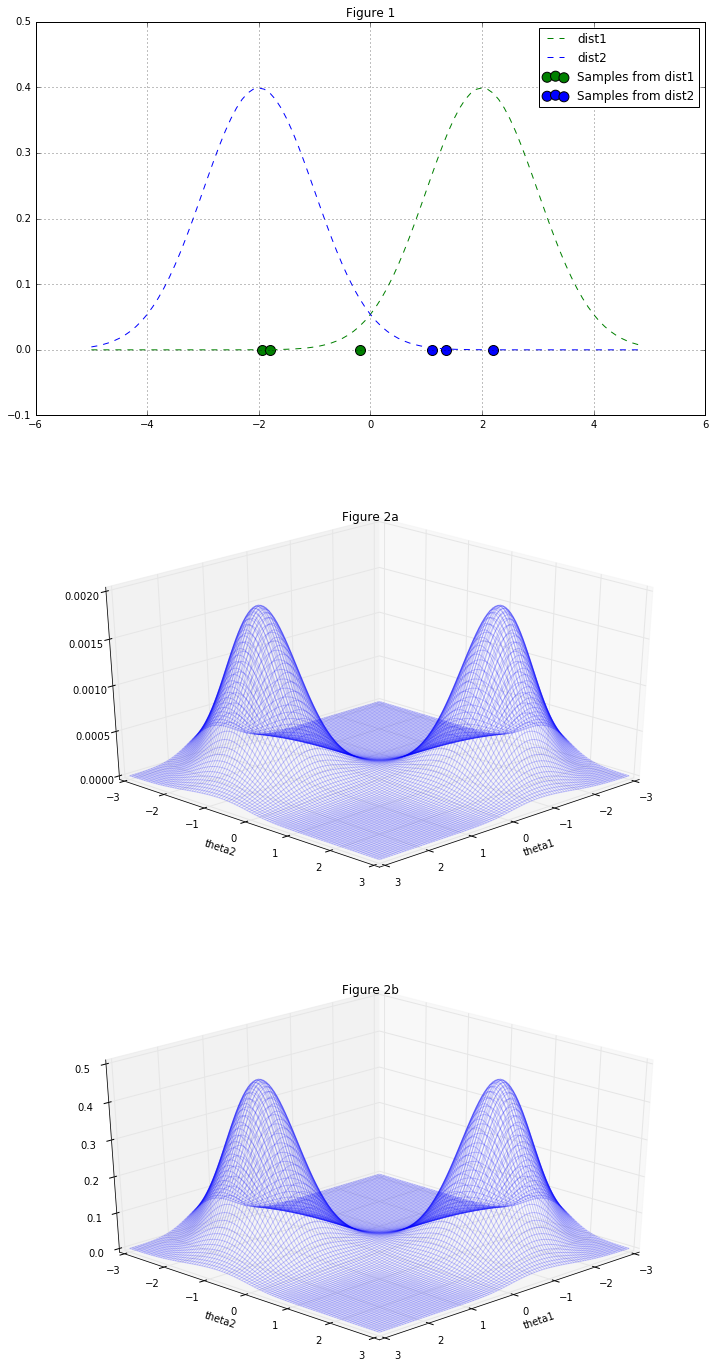

In [5]:
%matplotlib inline
##############
## FIGURE 1 ##
##############

# Assume two distributions with sigma=1 and mean=-2,2, respectively.
pdfrange = np.arange(-50,50)/10.0

# Plot the normal distributions
mu1 = 2.0
mu2 = -2.0
N = 20
norm1 = normval(pdfrange, mu1, 1)
norm2 = normval(pdfrange, mu2, 1)
fig = plt.figure(figsize=(12,24))
plt.subplot(311)
plt.plot(pdfrange, norm1, 'g--', label='dist1')
plt.plot(pdfrange, norm2, 'b--', label='dist2')

# Plot three samples from each
U1 = [-1.95, -1.8, -.18] # data from dist 1
U2 = [1.1, 1.35, 2.2] # data from dist 2
plt.scatter(U1, [0]*len(U1), c='g', marker='o', s=100, label='Samples from dist1')
plt.scatter(U2, [0]*len(U2), c='b', marker='o', s=100, label='Samples from dist2')
plt.legend()
plt.title('Figure 1')
plt.grid('on')

##############
## FIGURE 2 ##
##############

# My thinking here is that the probability of a data point xi 
# given mu1 and mu2 -- i.e. the probability of xi in a world
# where mu1 and mu2 are the means of the mixture components --
# is simply the sum of PDF(xi,mu1,sigma1) and PDF(xi,mu2,sigma2).
# So each point in the space below is the product of this sum
# across all data points in U.

ax = fig.add_subplot(312, projection='3d')
meanrange = np.linspace(-3,3,100)
XX,YY = np.meshgrid(meanrange, meanrange)
LF = np.zeros((len(meanrange), len(meanrange)))
U = np.concatenate([U1,U2],0)
for rr, mu1 in enumerate(meanrange):
    for cc, mu2 in enumerate(meanrange):
        LF[rr,cc] = np.prod(normval(U, mu1, 1) + normval(U, mu2, 1))
ax.plot_wireframe(XX,YY,LF,alpha=.2)
ax.view_init(30,45)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title('Figure 2a')


ax = fig.add_subplot(313, projection='3d')
meanrange = np.linspace(-3,3,100)
XX,YY = np.meshgrid(meanrange, meanrange)
LF = np.zeros((len(meanrange), len(meanrange)))
U = np.concatenate([U1,U2],0)
for rr, mu1 in enumerate(meanrange):
    for cc, mu2 in enumerate(meanrange):
        LF[rr,cc] = np.prod(normval(U, mu1, 1)*(1*np.sqrt(2*np.pi)) + normval(U, mu2, 1)*(1*np.sqrt(2*np.pi)))
        LF[rr,cc] = np.prod(uGivenMu(U, mu1, 1) + uGivenMu(U, mu2, 1))
ax.plot_wireframe(XX,YY,LF,alpha=.2)
ax.view_init(30,45)
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.title('Figure 2b')

**Figure 1**: mixture components and data. Data consists of three samples drawn from each mixture component, shown above as blue and green circles. The means of the mixture components are -2 and 2, respectively. So, the author is using the term "mixture component" to describe the two normal distributions. <font color='red'>Are the mixture components the J's in the Hmap equation above?</font>

**Figure 2a**: My attempt at computing likelihood function of the two component means theta1 and theta2, given the data in figure 1. Basically, the product across data points of the sum of joint PDFs per data point. Did that make sense?

$$\Pi_i\Sigma_j\frac{1}{\sigma \sqrt{2*\pi}}\exp{\frac{-(x_i - \mu_j )^2}{2\sigma^2}}$$

**Figure 2b**: <font color='red'>This more closely resembles the authors plot.</font> It looks like he ignored the 1/sigma constant in my equation above. Like this:

$$\Pi_i\Sigma_j\exp{\frac{-(x_i - \mu_j )^2}{2\sigma^2}}$$

## Define Expectation and Maximization Steps

In [6]:
meanrange = np.linspace(-3,3,100)

def Estep(U,THETAS,verbose=True):
    #Likelihood that data element U_i comes from cluster defined by mu_j
    posterior_probs = np.zeros((len(U), len(THETAS)))
    posterior_probs[:,0] = uGivenMu(U, THETAS[0])
    posterior_probs[:,1] = uGivenMu(U, THETAS[1])
    norm_term = np.sum(posterior_probs,axis=1)
    posterior_probs[:,0] = posterior_probs[:,0] / norm_term
    posterior_probs[:,1] = posterior_probs[:,1] / norm_term
    if verbose:
        print '{0:<10}{1:<15}{2:<15}'.format('ui', 'P(ui|theta1)', 'P(ui|theta2)')
        for rr, eachdata in enumerate(U):
            print '{0:<10}{1:<15.3f}{2:<15.3f}'.format(eachdata,
                                                 posterior_probs[rr, 0],
                                                 posterior_probs[rr, 1])
    return posterior_probs

def Mstep(U, prob_table, verbose=True):
    newtheta1 = np.sum(prob_table[:,0]*U)/np.sum(prob_table,axis=0)[0]
    newtheta2 = np.sum(prob_table[:,1]*U)/np.sum(prob_table,axis=0)[1]
    if verbose:
        print  '{0:<10}{1:<10}'.format('Theta1','Theta2')
        print '{0:<10.3f}{1:<10.3f}'.format(newtheta1, newtheta2)        
    return [newtheta1, newtheta2]


### Run EM

In [27]:
%matplotlib nbagg

# Pick a couple starting mu's (thetas)
mu1 = -0.5
mu2 =  0.5
mu1idx = np.argmin([abs(xx-mu1) for xx in meanrange])
mu2idx = np.argmin([abs(xx-mu2) for xx in meanrange])
THETAS = [mu1, mu2]
print  '{0:<10}{1:<10}'.format('Theta1','Theta2')
print '{0:<10.3f}{1:<10.3f}'.format(THETAS[0], THETAS[1])

# generate figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(XX, YY, LF, alpha=.1, label='True Likelihood Func')
Nsteps = 5

for ii, eachstep in enumerate(range(Nsteps)):
    # Expectation
    print "\nE-step (soft clustering) Iteration {0}".format(eachstep+1)
    prob_table = Estep(U, THETAS)
    likelihood = np.prod(uGivenMu(U, THETAS[0], 1) + uGivenMu(U, THETAS[1], 1))
#     LF_em = np.zeros_like(LF)
#     mu1idx = np.argmin([abs(xx-THETAS[0]) for xx in meanrange])
#     mu2idx = np.argmin([abs(xx-THETAS[1]) for xx in meanrange])
#     LF_em[mu1idx, mu2idx] = likelihood
#     ax.plot_wireframe(XX, YY, LF_em, alpha=.1, color=colors[ii])
    ax.scatter(THETAS[1],THETAS[0], likelihood, c='red')
    # Maximization
    print "\nM-step (cluster averages)"
    THETAS = Mstep(U, prob_table)


# finish off plot
ax.view_init(30,65)
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.title('Figure 3')
plt.legend()
plt.show()

Theta1    Theta2    
-0.500    0.500     

E-step (soft clustering) Iteration 1
ui        P(ui|theta1)   P(ui|theta2)   
-1.95     0.875          0.125          
-1.8      0.858          0.142          
-0.18     0.545          0.455          
1.1       0.250          0.750          
1.35      0.206          0.794          
2.2       0.100          0.900          

M-step (cluster averages)
Theta1    Theta2    
-0.910    1.042     

E-step (soft clustering) Iteration 2
ui        P(ui|theta1)   P(ui|theta2)   
-1.95     0.981          0.019          
-1.8      0.974          0.026          
-0.18     0.618          0.382          
1.1       0.117          0.883          
1.35      0.075          0.925          
2.2       0.015          0.985          

M-step (cluster averages)
Theta1    Theta2    
-1.263    1.315     

E-step (soft clustering) Iteration 3
ui        P(ui|theta1)   P(ui|theta2)   
-1.95     0.994          0.006          
-1.8      0.991          0.009          
-0.18    